In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SQLContext
# sc.stop()
# conf = pyspark.SparkConf().setAll([('spark.executor.memory', '5g'), ('spark.driver.maxResultSize', '12g'), ('spark.driver.memory','38g')])
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '12g'), ('spark.driver.memory','38g')])
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [2]:
from time import time
#from plot_utils import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from pyspark.mllib.tree import GradientBoostedTrees 
from pyspark.mllib.tree import GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils

In [ ]:
feature_text='lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'
features=[a.strip() for a in feature_text.split(',')]

In [ ]:
inputRDD=sc.textFile('HIGGS.csv') #Replace with actual path
inputRDD.first()

In [ ]:
Data = (inputRDD.map(lambda line: [float(x.strip()) for x in line.split(',')]).map(lambda line: LabeledPoint(line[0], line[1:])))
Data.first()

In [ ]:
Data1=Data.sample(False,0.01).cache()
(trainingData,testData) = Data1.randomSplit([0.7,0.3])

print ('Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count()))

In [ ]:
type(Data1)

In [ ]:
errors={} 
for depth in [1,3,6,10]:     
    start=time()        
    model=GradientBoostedTrees.trainClassifier(Data1,categoricalFeaturesInfo={}, numIterations=3)
    errors[depth]={}     
    dataSets={'train':trainingData,'test':testData}     
    for name in dataSets.keys():  
        # Calculate errors on train and test sets           
        data=dataSets[name]         
        Predicted=model.predict(data.map(lambda x: x.features))         
        LabelsAndPredictions=(data.map(lambda lp: lp.label).zip(Predicted))
        Err=(LabelsAndPredictions.filter(lambda v:v[0] != v[1]).count()/float(data.count()))         
        errors[depth][name]=Err     
    print(depth,errors[depth],int(time()-start),'seconds')
print(errors)

In [ ]:
errors={}
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier(Data1, numClasses=2, 
           categoricalFeaturesInfo={}, numTrees=3,  
           featureSubsetStrategy="auto", impurity='gini', 
           maxDepth=4, maxBins=32)
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():
        # Calculate errors on train and test sets
        data = dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=(data.map(lambda lp: lp.label).zip(Predicted))
        Err=(LabelsAndPredictions.filter(lambda v:v[0] != v[1]).count()/float(data.count()))
        errors[depth][name]=Err
    print(depth,errors[depth],int(time()-start),'seconds')
print(errors)

In [ ]:
## Clustering Starts - Siddhant

In [ ]:
inputRDD=sc.textFile('HIGGS.csv') #Replace with actual path
inputRDD.first()

In [ ]:
Data=(inputRDD.map(lambda line: [float(x.strip()) for x in line.split(',')]).map(lambda line: LabeledPoint(line[0], line[1:])))
Data.first()
clusteringData=Data.sample(False,0.01).cache()
(clusterTrain,clusterTest)=clusteringData.randomSplit([0.7,0.3])

In [ ]:
cTrain = clusterTrain.collect()
cTest = clusterTest.collect()

In [ ]:
clusterTrain.collect()[0]

In [ ]:
trainFeatures = clusterTrain.map(lambda lp: lp.features).collect()

In [ ]:
trainLabels = clusterTrain.map(lambda lp: lp.label).collect()

In [ ]:
trainLabels[1]

In [ ]:
trainDF = [x.toArray() for x in trainFeatures]
# trainLabelDF = [x.toArray() for x in trainLabels]
len(trainDF)
# len(trainLabelDF)

In [ ]:
trainDF[0]

In [ ]:
trainFeatures[0].toArray()

In [ ]:
clusteringData.collect()[0]

In [ ]:
# from pyspark.ml.clustering import KMeans
from sklearn.cluster import KMeans
# dataset = clusterTrain
dataset = trainDF
# Trains a k-means model.
# kmeans = KMeans().setK(2).setSeed(122)
kmeans = KMeans(n_clusters=2, random_state=0).fit(dataset)
model = kmeans.fit(dataset)
# model = kmeans.fit(dataset)
# Evaluate clustering by computing Within Set Sum of Squared Errors.
# wssse = model.computeCost(dataset)
# print("Within Set Sum of Squared Errors = " + str(wssse))
# Shows the result.
# centers = model.clusterCenters()
# print("Cluster Centers: ")
# for center in centers:
# print(center)

In [ ]:
from sklearn.metrics.cluster import completeness_score
transformed = model.predict(dataset)
# labels = dataset.select('Label').collect()
labels = trainLabels
label_array = [int(i) for i in labels]
preds = transformed
preds_array = [int(i) for i in preds]
completeness_score(preds_array, label_array)

In [ ]:
trainDF[0]

In [ ]:
from sklearn.cluster import SpectralClustering
# dataset = clusterTrain
dataset = trainDF
# Trains a k-means model.
# kmeans = KMeans().setK(2).setSeed(122)
spectral = SpectralClustering(n_clusters=2, random_state=23).fit(dataset)

In [ ]:
## Clustering Ends - Siddhant

In [3]:
df = sqlContext.read.format('com.databricks.spark.csv') \
    .options(header='false', inferschema='true') \
    .load('newhiggs.csv')

In [4]:
df.show(n=3)

+---+------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+----+------------------+--------------------+-------------------+------------------+------------------+--------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|_c0|               _c1|               _c2|                _c3|               _c4|                _c5|               _c6|               _c7|                _c8|               _c9|              _c10|               _c11|               _c12|_c13|              _c14|                _c15|               _c16|              _c17|              _c18|                _c19|               _c20|             _c21|              _c22|              _c23|              _c24|         

In [5]:
df.columns

['_c0',
 '_c1',
 '_c2',
 '_c3',
 '_c4',
 '_c5',
 '_c6',
 '_c7',
 '_c8',
 '_c9',
 '_c10',
 '_c11',
 '_c12',
 '_c13',
 '_c14',
 '_c15',
 '_c16',
 '_c17',
 '_c18',
 '_c19',
 '_c20',
 '_c21',
 '_c22',
 '_c23',
 '_c24',
 '_c25',
 '_c26',
 '_c27',
 '_c28']

In [6]:
featuredf = df.select([c for c in df.columns if c not in {'_c0'}])
labeldf = df.select('_c0')

In [7]:
featuredf.columns

['_c1',
 '_c2',
 '_c3',
 '_c4',
 '_c5',
 '_c6',
 '_c7',
 '_c8',
 '_c9',
 '_c10',
 '_c11',
 '_c12',
 '_c13',
 '_c14',
 '_c15',
 '_c16',
 '_c17',
 '_c18',
 '_c19',
 '_c20',
 '_c21',
 '_c22',
 '_c23',
 '_c24',
 '_c25',
 '_c26',
 '_c27',
 '_c28']

In [80]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=featuredf.columns,
    outputCol="features")

outputFeatureDf = assembler.transform(featuredf)
# output.select("name", "marks").show(truncate=False)

In [77]:
outputFeatureDf.show(n=2)

+-----------------+------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+----+------------------+--------------------+-------------------+------------------+------------------+-------------------+------------------+----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|              _c1|               _c2|                _c3|               _c4|                _c5|               _c6|               _c7|                _c8|               _c9|              _c10|               _c11|               _c12|_c13|              _c14|                _c15|               _c16|              _c17|              _c18|               _c19|              _c20|_c21|              _c22|              _c23|              _c24|              _c25|         

In [85]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
fDf = assembler.transform(featuredf)
model = pca.fit(fDf)
result = model.transform(fDf).select("pcaFeatures")


In [86]:
result.show(n=1)

+--------------------+
|         pcaFeatures|
+--------------------+
|[-0.6666785603882...|
+--------------------+
only showing top 1 row



In [87]:
from pyspark.ml.clustering import KMeans
dataset = outputFeatureDf
# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(122)
model = kmeans.fit(dataset)
# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(dataset)
print("Within Set Sum of Squared Errors = " + str(wssse))
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 1756128.2232971066
Cluster Centers: 
[ 9.94120779e-01  1.65566943e-03  1.35430120e-03  9.94234337e-01
  1.13900072e-03  9.91966250e-01  5.26925463e-03  4.99303853e-03
  1.18400062e+00  1.00200617e+00 -2.73370341e-03 -3.88735174e-03
  1.20014385e+00  1.00588645e+00 -4.67818126e-04 -3.85526395e-03
  1.23202579e+00  9.10353100e-01  6.00730696e-04  6.13707556e-04
  9.57159150e-05  9.70712713e-01  1.00924529e+00  1.05060095e+00
  1.03150359e+00  1.05438768e+00  1.04931957e+00  9.59912238e-01]
[ 9.89300411e-01  6.86958073e-03  3.69865618e-03  1.00014339e+00
 -6.60922163e-03  9.90963947e-01  4.60463331e-06  2.65455777e-03
  6.70593859e-01  9.70496456e-01  9.69152617e-04  3.99374947e-03
  6.28283629e-01  9.68209326e-01  8.55000637e-03 -1.05688768e-03
  5.67998245e-01  1.12643056e+00 -5.75010485e-03 -7.00632378e-03
  2.83967354e+00  1.15845159e+00  1.05775004e+00  1.04917807e+00
  9.69585437e-01  8.23303788e-01  1.00527755e+00  9.60178775e-01]


In [88]:
from sklearn.metrics.cluster import completeness_score
transformed = model.transform(dataset)
labels = labeldf.collect()
label_array = [int(i[0]) for i in labels]
preds = transformed.select('prediction').collect()
preds_array = [int(i.prediction) for i in preds]
completeness_score(preds_array,label_array)

0.0002445561854965075

In [90]:
ss = result.collect()

In [93]:
xPlot = [x.pcaFeatures[0] for x in ss]
yPlot = [x.pcaFeatures[1] for x in ss]

In [92]:
ss[0].pcaFeatures[0]

-0.6666785603882187

In [95]:
preds_array

[0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


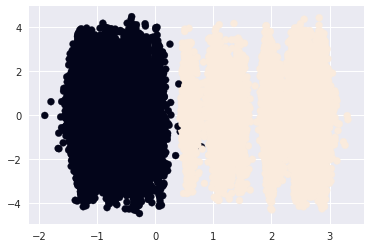

In [96]:
newPreds = []
plt.scatter(xPlot,yPlot,c=preds_array)

In [35]:
dataset = outputFeatureDf
kValues = [2,3,4,5,6,7,8]
wssse = []
for k in kValues:
    kmeans = KMeans().setK(k).setSeed(122)
    model = kmeans.fit(dataset)
    wssse.append(model.computeCost(dataset))
for i in wssse:
    print(i)

1756128.2232971068
1670338.0058839985
1598992.3161971876
1554197.6696090077
1515377.6082520082
1483102.5222801783
1456147.442021092


In [29]:
from pyspark.ml.clustering import BisectingKMeans
# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(2).setSeed(1222)
model = bkm.fit(outputFeatureDf)
# Evaluate clustering.
cost = model.computeCost(dataset)
print("Within Set Sum of Squared Errors = " + str(cost))
# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 1840253.3841598039
Cluster Centers: 
[ 0.99285683 -0.53934478 -0.00394638  0.99264094 -0.00372027  0.99146902
 -0.53424596  0.01064442  1.00630669  0.99167658 -0.52468419 -0.00893763
  1.00243943  0.99676032 -0.47638838 -0.00309932  1.03980939  0.97967738
 -0.41000355  0.0114886   0.93610895  1.03159741  1.02420132  1.05011418
  1.01081774  0.9773568   1.0336654   0.95894535]
[ 9.91990638e-01  5.48958735e-01  8.33437356e-03  1.00000363e+00
  5.56355577e-04  9.91758878e-01  5.43688444e-01 -2.33529289e-03
  1.00040621e+00  9.90159328e-01  5.24361097e-01  6.74666026e-03
  9.95424695e-01  9.88479897e-01  4.84122845e-01 -2.64093249e-03
  9.56778353e-01  9.93110714e-01  4.08717356e-01 -1.56890228e-02
  1.06254257e+00  1.04196119e+00  1.02843132e+00  1.05008640e+00
  1.00861354e+00  9.68788712e-01  1.03398301e+00  9.61071825e-01]


In [30]:
from sklearn.metrics.cluster import completeness_score
transformed = model.transform(dataset)
labels = labeldf.collect()
label_array = [int(i[0]) for i in labels]
preds = transformed.select('prediction').collect()
preds_array = [int(i.prediction) for i in preds]
completeness_score(preds_array,label_array)

6.87089431787806e-06

In [36]:
dataset = outputFeatureDf
kValues = [2,3,4,5,6,7,8]
bwssse = []
for k in kValues:
    bkmeans = BisectingKMeans().setK(k).setSeed(122)
    bmodel = bkmeans.fit(dataset)
    bwssse.append(bmodel.computeCost(dataset))
for i in bwssse:
    print(i)

1839682.795901591
1749090.7872491756
1637552.1481045212
1592325.4182351783
1532429.9398164868
1499270.1598056243
1477301.83325809


In [31]:
from pyspark.ml.clustering import GaussianMixture
gmm = GaussianMixture(predictionCol="prediction").setK(2).setSeed(538009335)
gmmmodel = gmm.fit(outputFeatureDf)
print("Gaussians shown as a DataFrame: ")
gmmmodel.gaussiansDF.show()

Gaussians shown as a DataFrame: 
+--------------------+--------------------+
|                mean|                 cov|
+--------------------+--------------------+
|[0.94894068389652...|0.256351088860961...|
|[1.25538325801927...|0.635926514139510...|
+--------------------+--------------------+



In [32]:
from sklearn.metrics.cluster import completeness_score
transformed = gmmmodel.transform(dataset)
labels = labeldf.collect()
label_array = [int(i[0]) for i in labels]
preds = transformed.select('prediction').collect()
preds_array = [int(i.prediction) for i in preds]
completeness_score(preds_array,label_array)

0.0013267158846559071

In [51]:
dataset = outputFeatureDf
kValues = [2,3,4,5,6,7,8]
gmmError = []
for k in kValues:
    gmm = GaussianMixture(predictionCol="prediction").setK(k).setSeed(538009335)
    gmmmodel = gmm.fit(dataset)
    transformed = gmmmodel.transform(dataset)
    labels = labeldf.collect()
    label_array = [int(i[0]) for i in labels]
    preds = transformed.select('prediction').collect()
    preds_array = [int(i.prediction) for i in preds]
    gmmError.append(completeness_score(preds_array,label_array))
for i in gmmError:
    print(i)

0.0013267158846559071
0.004619438419357973
0.00317696517024974
0.005745783079047163
0.005716580444519556
0.005294594252545824
0.00890182500427245


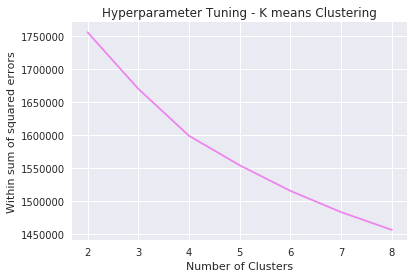

In [48]:
plt.plot(kValues,wssse, color="violet")
plt.xlabel('Number of Clusters')
plt.ylabel('Within sum of squared errors')
plt.title('Hyperparameter Tuning - K means Clustering')
plt.show()

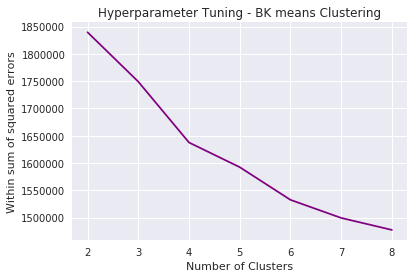

In [45]:
plt.plot(kValues,bwssse, color="purple")
plt.xlabel('Number of Clusters')
plt.ylabel('Within sum of squared errors')
plt.title('Hyperparameter Tuning - BK means Clustering')
plt.show()

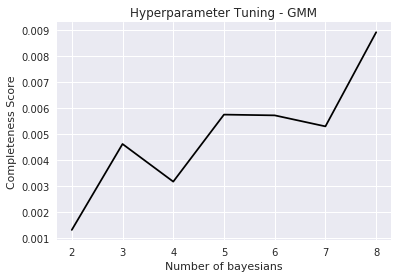

In [52]:
plt.plot(kValues,gmmError, color="black")
plt.xlabel('Number of bayesians')
plt.ylabel('Completeness Score')
plt.title('Hyperparameter Tuning - GMM')
plt.show()

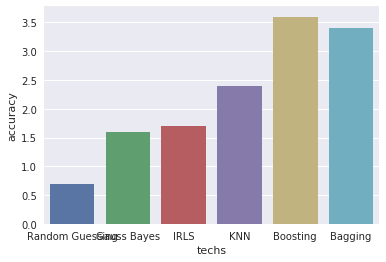

In [74]:
# Bar Plot
techs = ["Random Guessing", "Gauss Bayes", "IRLS", "KNN", "Boosting", "Bagging"]
acc = [0.7, 1.6, 1.7, 2.4, 3.6, 3.4]
ax = sns.barplot(x="techs", y="accuracy", data=pdnumsqr, capsize=.2)

In [73]:
# inputs
# In [41]: num = np.array([1, 2, 3, 4, 5])
# In [42]: sqr = np.array([1, 4, 9, 16, 25])

# convert to pandas dataframe
d = {'techs': techs, 'accuracy': acc}
pdnumsqr = pd.DataFrame(d)